# Quantification of shimming routines

In this Notebook, the general code used for quantitative analysis of the acquired data is presented. This is just a general example, and needs to be slightly modified based on the number of shimming routines assessed. For more details on the analysis done, contact the author.

In [1]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter
import scipy.ndimage
from skimage.filters import threshold_otsu # For testing binary mask
#from mpl_interactions import image_segmenter
# %matplotlib ipympl # Uncomment if you want to use the interactive plot (drawing out ROI)

# Useful packages for plotting
from matplotlib.pyplot import GridSpec
from matplotlib.colors import TwoSlopeNorm # For ensuring that the colorbar is symmetric around 0
from mpl_toolkits.axes_grid1 import make_axes_locatable # To move colorbar to left-hand size of plot

# Set LaTeX to render with Computer Modern font
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Computer Modern Roman']
plt.rcParams['text.usetex'] = True  # Enable LaTeX rendering

# The directoy to the specific scan's data
folder_data = '/Volumes/MasterStud/SCANS_shim_vol_2/SCANS/'

In [2]:
# The difference in echo time for both field maps (confirmed equal from protocol-pdf)
tau = (5.1 - 4.08) * 1e-3    # [ms] --> [s]

## Load the NIfTY files

In [3]:
def load_nifti(file, sequence, calc_field_map = False):
    ''' Load the NIfTI file, return the correctly oriented data based on sequence. If calc_field_map is True, the data is rescaled to be between -pi and pi, and converted to Hz.
    Input:
        file: str, path to the NIfTI file
        sequence: str, the sequence type ('fieldmap', 'ME_GRE', 'EPI')
        calc_field_map: bool, whether to calculate the field map
    Output:
        data: np.ndarray, the 3D image data
    '''
    # Load the file
    img = nib.load(file)
    data = img.get_fdata()

    if calc_field_map:
        # Get absolute maximum of phase image
        absmax = np.max(np.abs(data))

        # Rescale to be between -pi and pi
        data = data / absmax * np.pi

        # Convert the field map units to Hz (as eq. 2.18 in project thesis)
        data = data / (2 * np.pi * tau)

    # Rotate the data based on type of sequence
    if sequence == 'fieldmap':
        # Field maps are rotated clockwise and flipped upside down
        data = np.rot90(data, -1)
        data = np.flip(data, axis = 0)

    elif sequence == 'ME_GRE':
        # ME_GRE is rotated 90 degrees counter-clockwise
        data = np.rot90(data, 1)

    elif sequence == 'EPI':
        # EPI is rotated 90 degrees counter-clockwise and flipped upside down
        data = np.rot90(data, -1)
        data = np.flip(data, axis = 0)
    else:
        raise ValueError("Invalid sequence type. Must be 'fieldmap', 'ME_GRE', or 'EPI'.")
    
    return data

In [4]:
# Example usage of load_nifti
# Directory field map
dir_field_map_small_mean = folder_data + 'B0_small_ph/B0_small_ph_mean.nii.gz'

# Directory ME-GRE image
dir_small_C6 = folder_data + 'MGE_5TE_C6_small/MGE_5TE_C6_small_e1.nii.gz'

# Directory EPI image
dir_small_C6_mean = folder_data + 'EPI_C6_small/mean_EPI_C6_small.nii.gz'

# Load and rotate the images to correct orientation
field_map_C6 = load_nifti(dir_field_map_small_mean, 'fieldmap', calc_field_map = True)
me_gre_C6 = load_nifti(dir_small_C6, 'ME_GRE')
epi_C6 = load_nifti(dir_small_C6_mean, 'EPI')

## Extract ROI from SCT automatic segmentation

Details on the commands used to segment, as well as which images used as basis is found the Methods-section of the Master's thesis.

In [5]:
def extract_roi(dir_roi, dir = True, sequence = None, all_echos = None):
    ''' Extract the region of interest (ROI) from the NIfTI file. If dir is True, load the ROI from the file. If dir is False, use the already loaded ROI. If ME-GRE apply the ROI to all echos.
    Input:
        dir_roi: str, path to the NIfTI file containing the ROI
        dir: bool, whether to load the ROI from the file
        all_echos: list of np.ndarray, the ME-GRE images for each echo time
    Output:
        all_echos_roi: list of np.ndarray, the ME-GRE images for each echo time with the ROI applied
    '''
    # Load the ROI (can either load the roi or use the roi already loaded)
    if dir:
        roi = load_nifti(dir_roi, sequence)
    else:
        roi = dir_roi # ROI already loaded

    # For ME-GRE, apply the ROI to all echos
    if all_echos is not None:
        all_echos_roi = []
        for echos in all_echos:
            echo_roi = np.where(roi > 0.1, echos, np.nan) # 0.1 to threshold a non-binary mask due to transformation mp2rage to ME-GRE
            all_echos_roi.append(echo_roi)
        roi_data = all_echos_roi
    # If EPI or field map, directly apply the ROI to the image
    else:
        roi_data = np.where(roi > 0.1, 1, np.nan) # 0.1 ensures that a transformed mask from MP2RAGE  does not include 'ripples' in the mask

    return roi_data

In [6]:
# Example usage
# ROI field map
segmentation_field_map = extract_roi(folder_data + 'mp2rage/transformed_B0_small_rms_seg.nii.gz', sequence = 'fieldmap', dir = True)

# ROI ME-GRE
segmentation_me_gre = extract_roi(folder_data + 'MGE_5TE_C6_small/rms_image_C6_small_seg.nii.gz', sequence = 'ME_GRE', dir = True, all_echos = me_gre_C6)

# ROI EPI
segmentation_epi = extract_roi(folder_data + 'EPI_C6_small/mean_EPI_C6_small_seg_manual_corrected.nii.gz', sequence = 'EPI', dir = True)


----

## $B_0$ field maps

The analysis of the $B_0$ field maps include calculating the Hz field map and the gradient field map. A labeled spinal cord by vertebral level, using SCT, is used for regional analysis of the spinal cord.

### Common ROI

The field maps uses a common ROI to ensure equal amounts of voxels across the different shimming routines.

In [7]:
def find_common_roi(rois, img_affine, save = False):
    '''Find the common region of interest (ROI) between field maps of different acquisitions.
    Input:
        rois: list of np.ndarray, the ROIs for each acquisition
        save: bool, whether to save the common ROI as a NIfTI file
    Output:
        common_roi: np.ndarray, the common ROI
    '''
    common_voxels = []
    for i in range(len(rois) - 1):
        # Get the data for each ROI
        roi = rois[i]
        if i == 0:
            common_voxels = np.logical_and(np.isfinite(roi), np.isfinite(rois[i + 1])) # np.isfinite() is exclude NaN-values
        else:
            common_voxels = np.logical_and(common_voxels, np.isfinite(rois[i + 1]))

    # Make an inital common ROI to ensure equal size
    common_roi = np.full(rois[0].shape, np.nan)

    # Set the common voxels to 1 inside the common ROI
    common_roi[common_voxels] = 1

    if save:
        common_roi_save = np.rot90(common_roi, 1)
        # Flip the images on the horizontal axis (upside-down)
        common_roi_save = np.flip(common_roi_save, axis=1)

        common_roi_nifti = nib.Nifti1Image(common_roi_save, affine=img_affine.affine)
        nib.save(common_roi_nifti, folder_data + 'common_roi_2.nii.gz')

    return common_roi

In [8]:
# Example usage
# Load another field map to extract common roi from 
dir_field_map_2 = 'B0_mini_ph/B0_mini_ph_mean.nii.gz'
field_map_C6_2 = load_nifti(folder_data + dir_field_map_2, 'fieldmap', calc_field_map = True)
segmentation_field_map_2 = extract_roi(folder_data + 'mp2rage/transformed_B0_mini_rms_seg.nii.gz', sequence = 'fieldmap', dir = True)

common_roi = find_common_roi([segmentation_field_map, segmentation_field_map_2], field_map_C6, save = False)

### Labeled segmentation by vertebral level

In [9]:
# Define the colormap for labeled vertebrae with distinct colors
cmap = plt.get_cmap('tab20') # use this colormap when plotting the labeled vertebral levels

# Dictionary to map integer labels to vertebral level names
label_dict = {
    1: 'C1',
    2: 'C2',
    3: 'C3',
    4: 'C4',
    5: 'C5',
    6: 'C6',
    7: 'C7',
    8: 'T1',
    9: 'T2',
    10: 'T3'
}

In [10]:
# Load the labeled common ROI
common_roi_labeled = load_nifti(folder_data + 'common_roi_manual_cropped_labeled.nii.gz', sequence = 'fieldmap') # ROI from mp2rage transformed to RMS.

# Make all 0 values NaN for better visualizationin plots
common_roi_labeled[common_roi_labeled == 0] = np.nan

### Mask vertebrae for better visualizations

Binary mask by threshold_otsu was investigated, but showed poor results as the signal variation in the vertebrae was high. Additionally, regions furhter away from the receiver coil was canceled out as well.

In [11]:
slice_idx = 20 # CHANGE based on what slice you manually segmented
dir_mask_onlyVertebra = 'vertebrae_B0.nii.gz'

# Load the nifty image and orient correctly
mask_img_onlyVertebra = load_nifti(folder_data + dir_mask_onlyVertebra, calc_field_map=False, sequence = 'fieldmap')

# Convert to mask out the regions drawn as voi (vertebrae and background)
mask_img_onlyVertebra = np.logical_not(mask_img_onlyVertebra)

# Example usage
field_map_C6_vertebra = field_map_C6 * mask_img_onlyVertebra

### Regional standard deviation $B_0$ field maps

In [12]:
def calc_std(num_labels, data):
    ''' Calculate the standard deviation of the data for each label in the labeled common ROI.
    Input:
        num_labels: int, the number of labels in the labeled common ROI (8 for C7, 10 for T2)
        data: np.ndarray, the data to calculate the standard deviation for
    Output:
        std: np.ndarray, the standard deviation of the data for each label
        std_all: list of np.ndarray, the standard deviation of the data for each label in the common ROI
        std_total: float, the overall standard deviation of the data in the restricted common ROI
        mean_std: float, the mean standard deviation of the data in the restricted common ROI
    '''
    std_all = []
    std = []

    for label in range(1, num_labels):
        # Find the data of the current label
        label_data = np.where(common_roi_labeled == label, data, np.nan)

        if np.sum(label_data) == 0:
            # If the label data is empty, append NaN to the list
            std.append(np.nan)
            std_all.append(np.nan)
            continue
        else:
            # Calculate the standard deviation of the data for the current label
            std_label = np.nanstd(label_data)

            # Append the standard deviation to the list
            std.append(std_label)

            # Append the label data to the list for overall standard deviation calculation in specified regions
            std_all.append(label_data)
    
    std_total = np.nanstd(std_all)
    mean_std = np.nanmean(std_all)

    return std, std_all, std_total, mean_std

In [13]:
# Example usage
std_field_map, std_all_field_map, std_total_field_map, mean_std_field_map = calc_std(num_labels = 8, data = field_map_C6)

print(f'Standard deviation of field map C6: {std_field_map}')
print(f'Standard deviation of field map C6 in common ROI: {std_total_field_map}')
print(f'Mean standard deviation of field map C6 in common ROI: {mean_std_field_map}')

Standard deviation of field map C6: [np.float64(17.596926570775786), np.float64(19.97078606134873), np.float64(23.07244072448711), np.float64(20.807329609970004), np.float64(17.13222397738255), np.float64(18.123157613395104), np.float64(15.012852856841398)]
Standard deviation of field map C6 in common ROI: 33.918216996164276
Mean standard deviation of field map C6 in common ROI: 33.12693635153189


### Gradient field maps

In [14]:
def gaussian_smooth(field_map, sigma_s):
    '''Smooth the field map using a Gaussian filter.
    Input:
        field_map: np.ndarray, the field map to smooth
        sigma_s: float, the standard deviation of the Gaussian filter
    Output:
        field_map_smooth: np.ndarray, the smoothed field map
    '''
    # Smooth the field map using a Gaussian filter
    field_map_smooth = scipy.ndimage.gaussian_filter(field_map, sigma=sigma_s)
    
    return field_map_smooth

In [15]:
# Example usage
field_map_smooth = gaussian_smooth(field_map_C6_vertebra, sigma_s = 0.7)

In [16]:
# Calculate the field gradients
def calcGradients(field_map, axis = 1): 
    ''' Calculate the field gradients along the specified axis.
    Input:
        field_map: np.ndarray, the field map data
        axis: int, the axis to calculate the gradient along (0 = x, 1 = y, 2 = z)
    Output:
        grad_map: np.ndarray, the gradient map
    '''
    # Move the top line to the bottom
    rolled = np.roll(field_map, shift=-1, axis=axis) # shift = -1: Move top line to bottom

    # Calculate the local gradeint along the axis by subtracting the original
    grad_map =rolled - field_map

    # Divide by the voxel size to get [Hz/mm]
    grad_map = grad_map / 1.0 # Isotropic voxels (1x1x1mm^3)

    return grad_map

In [17]:
# Example usage
grad_map_z_smooth = calcGradients(field_map_smooth, axis = 1) # Gradient along the z-axis

In [18]:
def modulerize(grad_map):
    ''' Calculate the magnitude of the field map.
    Input:
        field_map: np.ndarray, the field map to calculate the magnitude for
    Output:
        field_map_magnitude: np.ndarray, the magnitude of the field map
    '''
    # Calculate the magnitude of the field map
    grad_map_magnitude = np.sqrt(grad_map**2)

    return grad_map_magnitude

In [19]:
# Example usage
grad_map_magn_z_smooth = modulerize(grad_map_z_smooth)

In [20]:
def gradient_quantification(gradient_map_smooth, num_labels, common_roi_labeled):
    '''Quantify the gradients in the common ROI.
    Input:
        gradient_map_smooth: np.ndarray, the smoothed gradient map
        num_labels: int, the number of labels in the labeled common ROI
        common_roi_labeled: np.ndarray, the labeled common ROI
    Output:
        mean_gradients: list of float, the mean gradient values for each label
    '''
    mean_gradients = []
    for label in range(1, num_labels):
        # Extract the gradient values for the specified label
        gradient_values = np.where(common_roi_labeled == label, gradient_map_smooth, np.nan)

        # Calculate the mean and median gradient values
        mean_gradient = np.nanmean(gradient_values)

        mean_gradients.append(mean_gradient)

    return mean_gradients

In [21]:
# Example usage
mean_gradients_field_map = gradient_quantification(grad_map_magn_z_smooth, num_labels = 8, common_roi_labeled = common_roi_labeled)
print(f'Mean gradients of field map C6: {mean_gradients_field_map}')

Mean gradients of field map C6: [np.float64(3.0145313184535083), np.float64(3.48326270654192), np.float64(5.376554128414262), np.float64(4.67927460873041), np.float64(3.683796895452379), np.float64(3.3467852471662987), np.float64(4.1033733997826545)]


----

## ME-GRE and signal loss across echoes

The analysis of signal loss in ME-GRE images revolves around the intensity ratio of the last (fifth) and first echo of the acquisition. The mean axial intensity rtio $dI4 is calculated andcompared across shimming routines.

### Chioce of quantification metric

In [22]:
def calc_metrics_dI(dI, num_slices):
    '''
    Function to caluclate metrics to quntify signal loss for a shimming algorithm using the intensity ratio dI. 
    NB: Takes in the entire list of dI values for all slices.
    Input:
        dI: np.ndarray, the intensity ratio data
        num_slices: int, the number of slices in the data
    Output:
        mean: list of float, the mean dI values for each slice
        std: list of float, the standard deviation of dI values for each slice
        median: list of float, the median dI values for each slice
        local_val: list of float, the local 10th percentile dI values for each slice
        percentile_10_global: float, the global 10th percentile of dI values
        percentile_10_all: float, the overall 10th percentile of all slices
        diff_mean_median: list of float, the difference between mean and median dI values for each slice
    '''
    
    mean = []
    std = []
    median = []
    local_val = []

    # Difference between mean and median
    diff_mean_median = []

    # Get the global 10th percentile (lower 10th percentile of the 10th percentile): Lower threshold for quatification
    percentile_10_global = np.nanpercentile([np.nanpercentile(dI[:, :, k], 10) for k in range(num_slices)], 10)

    # Get the overall 10th percentile of all slices
    all_voxels = np.concatenate([dI[:, :, k] for k in range(num_slices)])
    percentile_10_all = np.nanpercentile(all_voxels, 10)

    for i in range(num_slices):
        # Caclulate the mean
        mean.append(np.nanmean(dI[:, :, i]))

        # Standard deviation
        std.append(np.nanstd(dI[:, :, i]))

        # Median
        median.append(np.nanmedian(dI[:, :, i]))

        # Local value of 10th percentile
        local_val.append(np.nanpercentile(dI[:, :, i], 10))

        # Difference between mean and median
        diff_mean_median.append(mean[i] - median[i])

    return mean, std, median, local_val, percentile_10_global, percentile_10_all, diff_mean_median

In [23]:
def format_func(value):
    return f'{value:.2f}'  # Change the number of decimals here

def plot_all_algs(data1, data2, metric, data3 = None, report = False):
    ''' Example of plotting the data for two or three shimming routines.
    Input:
        data1: np.ndarray, the first data to plot
        data2: np.ndarray, the second data to plot
        metric: str, the metric to plot (e.g. 'mean', 'std', 'median', 'local_val', 'percentile_10_global', 'percentile_10_all', 'diff_mean_median')
        data3: np.ndarray, the third data to plot (optional)
        report: bool, whether to include a title in the plot
    Output:
        None
    '''
    plt.figure(figsize=(10, 5))
    plt.plot(data1[::-1], label='Data 1', color='blue')
    plt.plot(data2[::-1], label='Data 2', color='red')
    if data3 is not None:
        plt.plot(data3[::-1], label='Data 3', color='#17becf')
    plt.xlabel('Slice', fontsize = 28)
    plt.ylabel(f'{metric} dI', fontsize = 28)
    
    plt.gca().yaxis.set_major_formatter(FuncFormatter(format_func))

    # Set the font size for the tick labels
    plt.tick_params(axis='both', which='major', labelsize=26)
    
    if report == False:
        #plt.title(f'{metric} for all algorithms')
        plt.legend(fontsize = 22)
    plt.grid()
    plt.show()

### Intensity ratio maps

In the following cell, ane xample on how to obtain the intensity ratio map is shown.

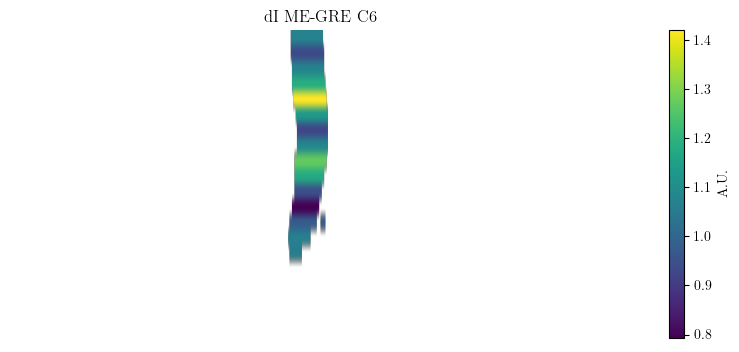

In [24]:
dI_me_gre = segmentation_me_gre[4] / segmentation_me_gre[0] # dI = I5 / I1


plt.figure(figsize=(10, 4))
plt.imshow(np.flipud(np.rot90(dI_me_gre[:, dI_me_gre.shape[1] // 2 + 1, :], -1)), aspect='auto') # Flip and rotate for correct orientation
plt.axis('off')
plt.title('dI ME-GRE C6')
plt.colorbar(label = 'A.U.')
plt.show()

---

## EPI

Calculate the SNR inside the semi-automatically segmented spinal cord from dividing the mean signal by the noise (standard deviation).

In [25]:
def calc_SNR(image_roi):
    ''' Calculate the signal-to-noise ratio (SNR) for the axial slices of the image.
    Input:
        image_roi: np.ndarray, the image data with the ROI applied
    Output:
        SNR: list of float, the SNR for each axial slice
    '''
    # Calculate the SNR for axial slices
    SNR = []
    for i in range(image_roi.shape[2]):
        signal = np.nanmean(image_roi[:, :, i])
        noise = np.nanstd(image_roi[:, :, i])
        SNR.append(signal / noise)
        
    return SNR